# Imports

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

import sys, re, os
import string, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils import data

import random
from datetime import datetime

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Google drive and Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "/content/drive/MyDrive/Sequence-Analysis-Projects"
twitter_path = os.path.join(drive_path, 'twitter-chatbot')
if not os.path.exists(drive_path):
    os.mkdir(drive_path)

projects = ['translation', 'twitter-chatbot']
for project in projects:
    project_path = os.path.join(drive_path, project)
    if not os.path.exists(project_path):
        os.mkdir(project_path)

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20_000
NUM_SAMPLES = 10_000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 512

bos = "<bos>"
eos = "<eos>"
pad = "<pad>"
unk = "<unk>"

# Utils

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [ ]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Original Text Preprocessing

In [ ]:
# load in the data
input_texts = []  # sentence in original language
target_texts = []  # sentence in target language
#target_text_inputs = []  #  sentence in target language offset by 1
t = 0
for line in open(os.path.join(twitter_path, "twitter_tab_format.txt")):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break
    line = line.rstrip()
    # input and targets are separeted by tab
    if "\t" not in line:
        continue

    # split up the input and translation
    input_text, target_text = line.split("\t")[:2]

    input_text, target_text = normalizeString(input_text), normalizeString(target_text)
  
    #target_text_input = "<sos> " + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    #target_text_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 8490


# Build Vocab

In [ ]:
def build_vocab(data):
    vocab = []
    for sentence in data:
        sentence_tokenized = word_tokenize(sentence)
        for word in sentence_tokenized:
            if word not in vocab:
                vocab.append(word)

    return vocab

In [ ]:
english_vocab = build_vocab(input_texts)
#english_vocab = build_vocab(train_inputs)
print(f"There is {len(english_vocab)} token in english_vocab")

There is 9571 token in english_vocab


In [ ]:
english_vocab = [pad, unk, bos, eos] + english_vocab


In [ ]:
word2idx_eng = {}
for i in range(len(english_vocab)):
    word2idx_eng[english_vocab[i]] = i

# map indexes back into real words
# so wwe can view the results
idx2word_eng = {v: w for w, v in word2idx_eng.items()}


In [ ]:
def build_sequences(texts, word2idx):
    sequences = []
    for sentence in texts:
        sequence = []
        sentence_tokenized = word_tokenize(sentence)
        for token in sentence_tokenized:
            if token in word2idx.keys():
                sequence.append(word2idx[token])
            else:
                sequence.append(word2idx[unk])
        sequences.append(sequence)
    return sequences


# Build train/test set

In [ ]:
N = len(input_texts)
indices = np.random.permutation(N)

N_train = 4 * N // 5

train_indices = list(indices[:N_train])
test_indices = list(indices[N_train:])

train_inputs = [input_texts[i] for i in train_indices]
train_targets = [target_texts[i] for i in train_indices]

test_inputs = [input_texts[i] for i in test_indices]
test_targets = [target_texts[i] for i in test_indices]


print("len(train_inputs):", len(train_inputs))
print("len(test_inputs):", len(test_inputs))

len(train_inputs): 6792
len(test_inputs): 1698


In [ ]:
#input_sequences = build_sequences(input_texts, word2idx_eng)
#target_sequences = build_sequences(target_texts, word2idx_eng)

input_sequences_train = build_sequences(train_inputs, word2idx_eng)
target_sequences_train = build_sequences(train_targets, word2idx_eng)

input_sequences_test = build_sequences(test_inputs, word2idx_eng)
target_sequences_test = build_sequences(test_targets, word2idx_eng)

print("len(input_sequences_train):", len(input_sequences_train))
print("len(input_sequences_test):", len(input_sequences_test))

#print("len(input_sequences):", len(input_sequences))
#print("len(target_sequences):", len(target_sequences))

len(input_sequences_train): 6792
len(input_sequences_test): 1698


In [ ]:
bos_idx = word2idx_eng[bos]
eos_idx = word2idx_eng[eos]
#input_sequences = [[bos_idx] + sequence + [eos_idx] for sequence in input_sequences]
# target_sequences_inputs = [[bos_idx] + sequence for sequence in target_sequences]
# target_sequences = [sequence + [eos_idx] for sequence in target_sequences]

target_sequences_train_inputs = [[bos_idx] + sequence for sequence in target_sequences_train]
target_sequences_train = [sequence + [eos_idx] for sequence in target_sequences_train]


target_sequences_test_inputs = [[bos_idx] + sequence for sequence in target_sequences_test]
target_sequences_test = [sequence + [eos_idx] for sequence in target_sequences_test]

In [ ]:
#max_len_input = max(len(s) for s in input_sequences)
max_len_input = max(len(s) for s in input_sequences_train)

print("max_len_input:", max_len_input)

max_len_input: 43


In [ ]:
max_len_target = max(len(s) for s in target_sequences_train)
#max_len_target = max(len(s) for s in target_sequences)

print("max_len_target:", max_len_target)

max_len_target: 38


# Loading Pre trained embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -qq glove.6B.zip


--2022-05-01 15:46:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-01 15:46:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-01 15:46:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# load in pre-trained word vectors
print("loading word vectors ...")
word2vec_path = 'glove.6B.%sd.txt'
word2vec = {}
with open(
    os.path.join(word2vec_path % EMBEDDING_DIM)
) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2]
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype="float32")
        word2vec[word] = vec
    print("Found %s word vectors." % len(word2vec))

loading word vectors ...
Found 400000 word vectors.


In [ ]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_NUM_WORDS, len(word2idx_eng))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_eng.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


# Dataset Interface

In [ ]:
# build data set
class TwitterDatset(data.Dataset):
    def __init__(self, max_len_input, max_len_target,input_sequences, target_sequences, target_sequences_inputs):
        self.max_len_input = max_len_input
        self.max_len_target = max_len_target
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences
        self.target_sequences_inputs = target_sequences_inputs

    def __len__(self):
        return len(self.input_sequences)

    def pad_input(self, sequence):
        max_len = self.max_len_input
        sequence_len = len(sequence)
        if sequence_len >= max_len:
            sequence = sequence[:max_len]
        else:
            sequence = [0] * (max_len - sequence_len) + sequence
        
        return sequence

    def pad_target(self, sequence):
        max_len = self.max_len_target
        sequence_len = len(sequence)
        if sequence_len >= max_len:
            sequence = sequence[:max_len]
        else:
            sequence = sequence + [0] * (max_len - sequence_len)  
        return sequence


    def __getitem__(self, idx):
        
        encoder_in = self.pad_input(self.input_sequences[idx])
        decoder_in = self.pad_target(self.target_sequences_inputs[idx])
        decoder_out = self.pad_target(self.target_sequences[idx])

        encoder_in = torch.LongTensor(encoder_in)
        decoder_in = torch.LongTensor(decoder_in)
        decoder_out = torch.FloatTensor(decoder_out)

    
        return encoder_in, decoder_in, decoder_out


# Dataset Setup 

In [ ]:
#twitter_dataset = TwitterDatset(max_len_input, max_len_target, input_sequences, target_sequences, target_sequences_inputs)

train_dataset = TwitterDatset(max_len_input, max_len_target, input_sequences_train, target_sequences_train, target_sequences_train_inputs)
test_dataset = TwitterDatset(max_len_input, max_len_target, input_sequences_test, target_sequences_test, target_sequences_test_inputs)

In [ ]:
# data_loader = torch.utils.data.DataLoader(
#     dataset=twitter_dataset,
#     shuffle=True,
#     batch_size=BATCH_SIZE)


train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE)

In [ ]:
# load pre-trained word embeddings into an embedding layer
# freeze the layer
embedding_layer = nn.Embedding(num_words, EMBEDDING_DIM)  # vocab size  # embedding dim
embedding_layer.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
embedding_layer.requires_grad = False


# Models

In [ ]:
# some configuration
# EMBEDDING_DIM = 100
# LATENT_DIM = 256
# T encoder = 4
class Encoder(nn.Module):
    def __init__(self, input_size,embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers # 1 or 2

        self.embedding = embedding_layer # vocab size x EMBEDDING_DIM
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)#, dropout=p) # -> T x N x 2*hidden

        self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size*2, hidden_size)
        
    def forward(self, x):
        # x shape: (N, T encoder) where N is batch size

        embedding = self.dropout(self.embedding(x)) # (T encoder, N, EMBEDDING_DIM)
        # embedding shape: # (T encoder, N, EMBEDDING_DIM)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        #  encoder_states shape:  (T encoder *num_layers , N, 2*hidden_size) 
        # hidden, cell : (2*num_layers, N, hidden_size) bidirectional = True
        
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
        # now : hidden, cell : (num_layers, N, hidden_size) 
        
        return encoder_states, hidden, cell
    

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size # LATENT_DIM
        self.num_layers = num_layers  # 1 or 2
 
        self.embedding = nn.Embedding(input_size, embedding_size) # input size = vocab fr size = num_words_output
        self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers)#), dropout=p) 
        # -> T decoder x N x hidden
       
        self.energy = nn.Linear(hidden_size*3,1)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size) # ->  T x N x output size

        
        
    def forward(self, x, encoder_states, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (N, 1), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0) # -> (1, N)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # (sequence_length * num_layers, N, hidden_size)
            
        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # -> (sequence_length, N, 1)
        attention = self.softmax(energy) 
        #(sequence_length, N, 1)
        attention = attention.permute(1,2,0)
        #(N, 1, sequence_length)
        encoder_states = encoder_states.permute(1,0,2)
        #(N, T, 2*hidden)
            
        context_vector = torch.bmm(attention, encoder_states).permute(1,0,2)
        # (N, 1, 2*hidden) -> (1, N, 2*hidden)
        
        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)
        
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # (1, N, 2*hidden + embedding_size) ->(1, N,  hidden)
        # outputs shape: (1, N,  hidden)
        # hidden, cell: (1, N,  hidden)

        predictions = self.fc(outputs)
        # -> (1, N, output_size)

        # predictions shape: (N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell
        # 


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, teacher_force_ratio=1):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_force_ratio = teacher_force_ratio

    def forward(self, source, target):
        # source = encoder_inputs
        # target = encoder_inputs
        batch_size = source.shape[1] # source (T_encoder, N)
        target_len = target.shape[0] # target (T_decoder, N)
        target_vocab_size = len(word2idx_eng) # check this is correct num_words = len(word2idx_outputs) + 1 

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) # (T_decoder, N, vocab)

        encoder_states, hidden, cell = self.encoder(source) # (num_layers, N, hidden_size) 

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0] # (1, N)
        outputs[-1] = word2idx_eng[eos] * torch.ones(batch_size, target_vocab_size).to(device)

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            #hidden, cell = hidden.squeeze(1), cell.squeeze(1)
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store next output prediction
            outputs[t-1] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < self.teacher_force_ratio else best_guess

        return outputs


# Training setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [ ]:
input_size_encoder = num_words
input_size_decoder = num_words
output_size = num_words
encoder_embedding_size = EMBEDDING_DIM
decoder_embedding_size = EMBEDDING_DIM
hidden_size = LATENT_DIM  # Needs to be the same for both RNN's
num_layers = 1
enc_dropout = 0.5
dec_dropout = 0.5
teacher_force_ratio = 0.5
# Training hyperparameters
num_epochs = 300
learning_rate = 0.001
batch_size = 64

In [ ]:
encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

In [ ]:
model = Seq2Seq(encoder_net, decoder_net, teacher_force_ratio).to(device)

In [ ]:
model = torch.load('./twitter_chatbot.pth')

In [ ]:
# loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-3)
model.train()

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(9575, 200)
    (rnn): LSTM(200, 512, bidirectional=True)
    (fc_hidden): Linear(in_features=1024, out_features=512, bias=True)
    (fc_cell): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(9575, 200)
    (rnn): LSTM(1224, 512)
    (energy): Linear(in_features=1536, out_features=1, bias=True)
    (softmax): Softmax(dim=0)
    (relu): ReLU()
    (fc): Linear(in_features=512, out_features=9575, bias=True)
  )
)

# Train loop

In [ ]:
num_epochs = 100

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    print(f"[Epoch {epoch+1} / {num_epochs}]")

    model.train()
    for batch_idx, batch in enumerate(train_loader):
        train_loss = []
        # Get input and targets and get to cuda
        # encoder_in, decoder_in, decoder_out
        encoder_in, decoder_in, target = batch
        encoder_in, decoder_in, target = encoder_in.to(device), decoder_in.to(device), target.to(device)
        encoder_in, decoder_in, target = encoder_in.permute(1,0), decoder_in.permute(1,0), target.permute(1,0)

        # Forward prop
        output = model(encoder_in, decoder_in)

        # Output is of shape (batch_size, trg_len, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have batch_size * output_words that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        #output = output[1:].reshape(-1, output.shape[2])
        #target = target[1:].reshape(-1)
        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        loss = criterion(output, target.long())

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        train_loss.append(loss.item())
    
    model.eval()
    for batch_idx, batch in enumerate(test_loader):
        test_loss = []
        # Get input and targets and get to cuda
        # encoder_in, decoder_in, decoder_out
        encoder_in, decoder_in, target = batch
        encoder_in, decoder_in, target = encoder_in.to(device), decoder_in.to(device), target.to(device)
        encoder_in, decoder_in, target = encoder_in.permute(1,0), decoder_in.permute(1,0), target.permute(1,0)
  
        # Forward prop
        output = model(encoder_in, decoder_in)

        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)
        loss = criterion(output, target.long())
        test_loss.append(loss.item())
    
    epoch_train_loss = np.mean(train_loss)           
    train_losses[epoch] = epoch_train_loss

    epoch_test_loss = np.mean(test_loss)           
    test_losses[epoch] = epoch_test_loss

    print(f'Train Loss: {epoch_train_loss:.3f}, Test Loss: {epoch_test_loss:.3f}')




[Epoch 1 / 100]
Train Loss: 2.889, Test Loss: 2.251
[Epoch 2 / 100]
Train Loss: 2.864, Test Loss: 2.534
[Epoch 3 / 100]
Train Loss: 2.880, Test Loss: 2.204
[Epoch 4 / 100]
Train Loss: 2.360, Test Loss: 2.185
[Epoch 5 / 100]
Train Loss: 1.958, Test Loss: 2.112
[Epoch 6 / 100]
Train Loss: 1.738, Test Loss: 2.099
[Epoch 7 / 100]
Train Loss: 1.592, Test Loss: 2.296
[Epoch 8 / 100]
Train Loss: 2.394, Test Loss: 2.099
[Epoch 9 / 100]
Train Loss: 3.012, Test Loss: 2.214
[Epoch 10 / 100]
Train Loss: 2.220, Test Loss: 2.165
[Epoch 11 / 100]
Train Loss: 2.260, Test Loss: 2.227
[Epoch 12 / 100]
Train Loss: 1.948, Test Loss: 2.191
[Epoch 13 / 100]
Train Loss: 1.730, Test Loss: 2.246
[Epoch 14 / 100]
Train Loss: 2.288, Test Loss: 2.237
[Epoch 15 / 100]
Train Loss: 2.454, Test Loss: 2.250
[Epoch 16 / 100]
Train Loss: 1.978, Test Loss: 2.178
[Epoch 17 / 100]
Train Loss: 2.637, Test Loss: 2.265
[Epoch 18 / 100]
Train Loss: 1.898, Test Loss: 2.166
[Epoch 19 / 100]
Train Loss: 1.148, Test Loss: 2.288
[E

# Loss and Evaluation

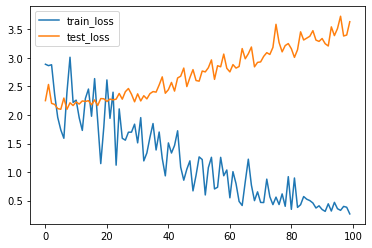

In [ ]:
# some plots
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [ ]:
#torch.save(model, './twitter_chatbot.pth')
torch.save(model, os.path.join(twitter_path, f"twitter_chatbot.pth"))


# Evaluating

In [ ]:
softmax = nn.Softmax(dim=1)
def decode_sequence(input_seq, mode="greedy"):
    # encode the input as state vectors.
    input_seq = input_seq.to(device)
    with torch.no_grad():
        encoder_states, h, c = encoder_net(input_seq)

        # generate empty target seq of length 1
        target_seq = torch.zeros(1).int().to(device)

        # populate the first character of target sequence with the start character
        # NOTE: tokenizer lower cases all words
        target_seq[0] = word2idx_eng[bos]

        # if we get this we break
        eos_idx = word2idx_eng[eos]

        # create translation
        output_sentence = []
        for _ in range(max_len_target):
            output_tokens, h, c = decoder_net(target_seq, encoder_states, h, c)

            if mode == "sample":
                probs = softmax(output_tokens).view(-1)
                idx = np.random.choice(len(probs), p=probs.detach().cpu().numpy())

            else:
                # get next word
                idx = output_tokens.argmax(1).item()

            # end of sentence EOS
            if eos_idx == idx:
                break

            word = ""
            if idx > 0:
                word = idx2word_eng[idx]
                output_sentence.append(word)

            # update the decoder input
            # which is just the word just generated
            target_seq[0] = idx
            #states_value = [h, c]

        return " ".join(output_sentence)

# Answers On train set

In [ ]:
encoder_net = model.encoder
decoder_net = model.decoder
while True:
    # do some answering
    i = np.random.choice(len(train_dataset))
    input_seq, _, _ = train_dataset[i]
    input_seq = input_seq.unsqueeze(1)
    pred_answer = decode_sequence(input_seq, mode="sample")
    true_answer = train_targets[i]
    print("_")
    print("Input:", train_inputs[i])
    print("True answer:", true_answer)#[:-5])
    print("Predicted:", pred_answer)
    

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith("n"):
        break


_
Input: whoa sorry there champ my kid goes there so i was looking for updates didnt know it was a problem reply u relax
True answer: oh i apologize not sure what s happening there right now
Predicted: oh i apologize not sure what s happening there right now
Continue? [Y/n]
_
Input: well since you re up . . . .
True answer: lol noo who do u think i am your maid ?
Predicted: lol noo who do u think i am your maid ?
Continue? [Y/n]
_
Input: starting today any brock excuses needs to stay off my tl . he needs more time not big enough sample size or any other bullshit go elsewhere
True answer: he plays its not for football reasons . play the other guy . find out . stay with brock lose the team . they know .
Predicted: he plays its not for football reasons . the the guy . . find out . stay out . brock lose the team . they know they
Continue? [Y/n]
_
Input: i blame trump for a lot of this tbh .
True answer: the few who ve come into my mentions saying random ignorant shit have been trump suppor

# Answers on test set

In [ ]:
while True:
    # do some answering
    i = np.random.choice(len(test_dataset))
    input_seq, _, _ = test_dataset[i]
    input_seq = input_seq.unsqueeze(1)
    pred_answer = decode_sequence(input_seq, mode="sample")
    true_answer = test_targets[i]
    print("_")
    print("Input:", test_inputs[i])
    print("True answer:", true_answer)#[:-5])
    print("Predicted:", pred_answer)
    

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith("n"):
        break

_
Input: i still need other stuff to do though
True answer: idk quilting is time consuming af lol but a cooking class or art class or something ? i would die . it sounds so fun
Predicted: they never get that cab
Continue? [Y/n]
_
Input: and both girls with him looked like barbie dolls from wwe too idk so many unanswered questioms
True answer: one is his wife who was a former wwe wrestler .other one i think is ultimate warriors widow
Predicted: people thing i all lot she s me cause . do with kassouf to play with the but at a big man
Continue? [Y/n]
_
Input: yes because seventeen comes after sixteen and you were born almost seventeen years ago
True answer: lmao i still feel like a child
Predicted: the this is why everyone while i m still there
Continue? [Y/n]
_
Input: no he replied he even sent another one
True answer: ohhhh well then
Predicted: if . was was just !
Continue? [Y/n]
_
Input: go
True answer: it was just pudding
Predicted: just look tomorrow thursday
Continue? [Y/n]
_
Input:

# Custom tweet answer

In [ ]:
def build_sequences_tweet(tweet, word2idx):
    tweet_tokenized = word_tokenize(tweet)
    tweet_seq = []
    unk_idx = word2idx_eng[unk]
    for word in tweet_tokenized:
        tweet_seq.append(word2idx_eng.get(word, unk_idx))
    
    return tweet_seq


In [ ]:
def answer_tweet(tweet, mode="greedy"):
    tweet_seq = build_sequences_tweet(tweet, word2idx_eng)
    tweet_seq = torch.LongTensor(tweet_seq).unsqueeze(1)
    return decode_sequence(tweet_seq, mode)

In [ ]:
tweet = "im going to watch some football tonight and eat chinese"
answer_tweet (tweet, "sample")

'what sports ?'